# Thermal background of Fiber IRMOS

# Nick Konidaris
1 May 2019

In [38]:
import numpy as np
%matplotlib inline
from pylab import *

import scipy.integrate
import scipy




from collections import namedtuple

import numpy as np
%matplotlib inline
from pylab import *

import astropy
from astropy import units as ur
from astropy import constants as cc
import astropy.modeling.blackbody

from astropy.convolution import convolve, Box1DKernel
K = ur.Kelvin

hc = cc.h * cc.c




## Introduction

The thermal background of fiber irmos is computed.

Here I tabulate the Étendue of various systems preceeindg the fiber tip. These Etendues are useful because one can add them together and multiply by the blackbody spectral radiance to compute a thermal background for the instrument. Recall that for some spectral radiance $L_{e \Omega \lambda}$ in units of $\left[ Power/Bandwidth/Area/Solid\ angle \right]$ there is an Étendue ($G$) that will yield a Spectral flux $\Phi_e = L_{e \Omega \lambda} \cdot G$. 

Our goal with fiber IRMOS is to produce an instrument whose Étendue from the spectrograph is only a fraction of the Étendue from the telescope. So it is worth computing the Étendue of the telescope first. I use various approximations that are useful.

$\Omega \approx \pi \sin^2 \theta$ and this is equivalent to $\Omega \approx \frac{\pi}{(2\cdot f/\#)^2}$

$G_{telescope} = \Omega_{telescope} \cdot A_{telescope} \cdot \epsilon_{telescope} = 3.61E-6\cdot cm2\cdot sr$ (see below)


In [32]:
def theta_to_omega(theta_rad):
    
    return np.pi * np.sin(theta_rad)**2 * ur.steradian

def fnum_to_omega(fnum):
    return np.pi /(2*fnum)**2 * ur.steradian

In [103]:
# Important constants


ϵ_world = 1

# Corrector
suprasil301transmissivity = 93.39/93.82

# FOREOPTICS
final_focal_ratio = 3.5 # This is the final focal ratio entering the fiber
fiber_focal_ratio = 3.0 # Given by the manufacturer
refl_ar_coating = 0.99 # I hope
τ_s_lah71 = -np.log(0.959)/10.

# FIBER
fiber_ffov = 0.8 * ur.arcsecond
fiber_diameter = 100 * ur.micron
ϵ_fiber = .05

# TELESCOPE
Dtel = 6.5 * ur.meter
n_mirrors = 2
refl_mirror = .95
fnum_tel = 11

# CORRECTOR
t_corr = 75.8 # cm

#### DERIVED
Atel = (np.pi * (Dtel/2)**2).to(ur.cm**2)*.93
Asecondary = Atel * 0.074 # from http://www.lco.cl/telescopes-information/magellan/magellan-telescopes/#figure1
ϵ_tel = 1 - refl_mirror**n_mirrors
A_fiber = np.pi*(fiber_diameter/2)**2
Gus = ur.cm**2 * ur.sr
ϵ_corr = 1-10**(-t_corr*0.001)


def p_h(varname):
    val = eval(varname)
    print("{0:25s} is {1:1.2e} or {2:3.0f}% of telescope".format(varname, val, val/G_telescope*100))

In [87]:
try:
    dat
except:
    dat = np.loadtxt("../K-band-background/atran/atran.plt.14451.dat.txt")

In [88]:
lams = dat[:,1] * ur.micron

goal = 2.4*ur.micron/3400
delt = lams[1]-lams[0]
N = np.int(np.ceil(goal/delt))
kernel = Box1DKernel(N)



lams = lams[::N]
ϵ_atm = (1 - convolve(dat[:,2], kernel))[::N]


If I raytrace $10^6$ rays and give the ball lens a 50% coating then zemax reports $147,854$ rays return in a 1st order ghost. With a 99% coathing zemax reports $9,720$ rays are sent to the 1st order ghost.

In [98]:
G_pixel = (theta_to_omega(1.5) * (18*ur.micron)**2)

In [99]:
G_pixel

<Quantity 1012.7828209 micron2 sr>

In [89]:
G_telescope = (theta_to_omega(fiber_ffov) * Atel).to(Gus)

p_h("G_telescope")

G_telescope               is 1.46e-05 cm2 sr or 100% of telescope


###  Fiber etendue -- first order

For the purposes of thermal background, I am most concerned with the étendue of the area outside the controlled f/# as defined by the manufacturer of the fiber. I also compute the étendue of the secondary assuming the spectrograph's internal Lyot stop will not block the secondary. I assume the world has unit emissivity.


In [66]:
EPP = 1.235e+004*ur.mm
Omega_baffles = theta_to_omega(np.arctan(fiber_diameter/EPP))

G_secondary = (Omega_baffles * A_baffles).to(Gus)
G_fiber = (np.abs(fnum_to_omega(final_focal_ratio) - fnum_to_omega(fiber_focal_ratio)) * A_fiber).to(Gus)

p_h("G_secondary")
p_h("G_fiber")

G_secondary               is 9.39e-07 cm2 sr or   6% of telescope
G_fiber                   is 1.82e-06 cm2 sr or  12% of telescope


###  Fiber etendue -- second order

0th order attributes of a fiber sytem are shown in the figure below under the assumption that a ball lens is used to reduce the focal ratio of the telescope. 

![0th order fiber trace](fiber_0th_order.png)

While the 0th order system is a useful place to start, there are ghost images that appear after 1 bounce. These are "first order ghosts" and are shown in the image below

![first order ghost fiber trace](fiber_1st_order.png)

If I raytrace $10^6$ rays and give the ball lens a 50% coating then zemax reports $147,854$ rays return in a 1st order ghost. With a 99% coating zemax reports $9,720$ rays are sent to the 1st order ghost. 

Note that only odd-order ghosts go to the "left" in the figure above, and even-order ghosts go to the right. As the ghost order increases the rays bounce around more and become more angularly homogeneous, so to overestimate their contribution I assume any ghosts higher than second order come from $4\pi$. It turns out that even with their solid angle overestimated, ghosts higher than 1st order benefit from $\epsilon^{ghost\ order}$ and so only the first-order ghosts matter. 

In [67]:
G_first_order = (theta_to_omega(36*ur.degree) * A_fiber ).to(Gus)
G_second_order = (theta_to_omega(36*ur.degree) * A_fiber ).to(Gus)
G_third_order = (4*np.pi*ur.sr * A_fiber ).to(Gus)

p_h("G_first_order")
p_h("G_second_order")
p_h("G_third_order")

G_first_order             is 8.52e-05 cm2 sr or 585% of telescope
G_second_order            is 8.52e-05 cm2 sr or 585% of telescope
G_third_order             is 9.87e-04 cm2 sr or 6767% of telescope


### Ball lens emissivity

The ball lens, made of S-LAH71 has an internall transmissivity for a tiny thickness (.7 mm). Its transmissivity is derived from the spec sheet.

In [68]:
G_ball_lens = (fnum_to_omega(fiber_focal_ratio) * A_fiber ).to(Gus)

G_ball_lens = (fnum_to_omega(fiber_focal_ratio) * A_fiber ).to(Gus)


p_h("G_ball_lens")

G_ball_lens               is 6.85e-06 cm2 sr or  47% of telescope


### Corrector emissivity

suprasil301transmissivity is from the Heraeus web calculator at 2.45µm where the transmissivity of a 100-mm thick sample of Suprasil 301 is 93.39% and the Fresnel losses are 93.82%. 

In [69]:
G_corrector = (fnum_to_omega(fnum_tel * final_focal_ratio/fiber_focal_ratio) * A_fiber).to(Gus)

p_h("G_corrector")

G_corrector               is 3.75e-07 cm2 sr or   3% of telescope


### Fiber attenuation

Based on communications from Le Verre Fluore the fiber attenuation in the thermal is 2 db / km

In [70]:
t_fiber = 10**(2/10*30/1000)-1

In [71]:
G_fiber_transmissivity = (fnum_to_omega(final_focal_ratio) * A_fiber ).to(Gus)
p_h("G_fiber_transmissivity")

G_fiber_transmissivity    is 5.04e-06 cm2 sr or  35% of telescope


## Summary

In [72]:


vs = ["G_telescope", "G_secondary", "G_fiber", "G_first_order", "G_second_order", "G_third_order", 
      "G_ball_lens", "G_corrector", "G_fiber_transmissivity"]

vs = ["G_telescope", "G_secondary",   "G_fiber_transmissivity",      "G_ball_lens", "G_corrector"]


G_tot = 0
for ix,v in enumerate(vs):
    p_h(v)
    
    if ix > 0: G_tot += eval(v)

print()
p_h("G_tot")

G_telescope               is 1.46e-05 cm2 sr or 100% of telescope
G_secondary               is 9.39e-07 cm2 sr or   6% of telescope
G_fiber_transmissivity    is 5.04e-06 cm2 sr or  35% of telescope
G_ball_lens               is 6.85e-06 cm2 sr or  47% of telescope
G_corrector               is 3.75e-07 cm2 sr or   3% of telescope

G_tot                     is 1.32e-05 cm2 sr or  91% of telescope


# Atmosphere

In [73]:
def model(lam, grasp, emissivity, efficiency=0.3, temp=300*K):
    """ Return BB curve for the reflective component of a telescope system
    
    Args:
        lam[] -- Wavelengths [L] to consider
        grasp -- Grasp of system in cm2 sr
        emissivity[] -- emissivity of system at that wavelength
        temp -- temperature
        
    Returns:
        Spectrum in units of 1/(s Angstrom) with same dimensionality as lam
     """
    epp = hc/lam

    # Specific spectral radiance in photon / sr/ m2 / bw
    L_e_Omega_lam = astropy.modeling.blackbody.blackbody_lambda(lam, temp)
        
    Phi_lam = L_e_Omega_lam * grasp * emissivity # Phi_lam is [Power]/[Bandwidth]
    N_lam = Phi_lam/epp # N_lam is [Hz]/[Bandwidth]
    
    nlam = N_lam.to(ur.Hertz/ur.angstrom) / (ur.Hertz/ur.angstrom) * efficiency
    flam = L_e_Omega_lam * (1*ur.arcsecond)**2 * emissivity * efficiency

    return nlam, flam.to(ur.erg/ur.second/ur.Angstrom/ur.cm**2)

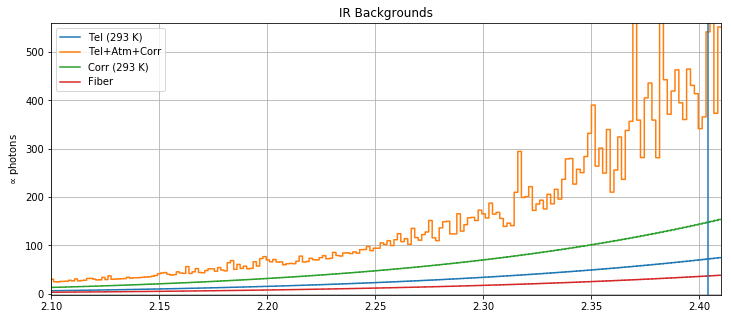

In [111]:
back_tel = model(lams, G_pixel, ϵ_tel, temp=293*ur.Kelvin)[0]
back_atm = model(lams, G_pixel, ϵ_atm)[0]
back_adc = model(lams, G_pixel, ϵ_corr/.8, temp=293*ur.Kelvin)[0]
back_fiber = model(lams, G_pixel, ϵ_fiber, temp=293*ur.Kelvin)[0]


figure(figsize=(12,5))
S=np.sqrt
step(lams, back_tel)
step(lams, back_tel + back_atm + back_adc + back_fiber)
step(lams, back_adc)
step(lams, back_fiber)

#yscale("log")
xlim(2.1,2.41)
axvline(2.404)
ylim(-2,560)

ylabel(r"$\propto$photons")

legend(["Tel (293 K)", "Tel+Atm+Corr", "Corr (293 K)", "Fiber"])
title("IR Backgrounds")
grid(True)

In [107]:
ϵ_corr, ϵ_tel

(0.1601533388420855, 0.09750000000000003)

In [106]:
ϵ_fiber

0.05